# Defect_Classification_CNN

* Written by: Angelo D. Bonzanini and Ketong Shao
* Date: June-July 2021

<< Code Desctription >>

## Imports

In [1]:
# General
import numpy as np
import matplotlib.pyplot as plt
import os

# Tensorflow
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D
from tensorflow.keras.layers import MaxPool2D, Flatten, Dense, Dropout
from tensorflow.keras import Model

# Mount Google Drive
from google.colab import drive
drive.mount('/content/gdrive')
execution_path = '/content/gdrive/MyDrive/Colab Notebooks/Code/ML-for-plasmas'

Mounted at /content/gdrive


## Load pre-processed training data

In [2]:
imgTrain = np.load(execution_path+'/../Data/imgTrain.npy')
specTrain = np.load(execution_path+'/../Data/specTrain.npy')
yTrainCat = np.load(execution_path+'/../Data/yTrain.npy')

imgTrain shape  =  (23880, 140, 140, 3)
specTrain shape =  (23880, 4096)
yTrain shape    =  (23880, 8)


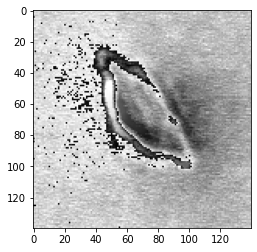

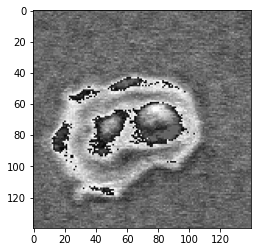

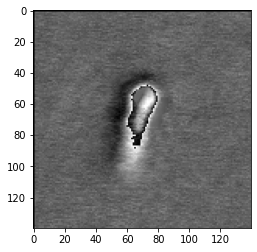

In [3]:
# Check dimensions an plot
print('imgTrain shape  = ', imgTrain.shape)
print('specTrain shape = ', specTrain.shape)
print('yTrain shape    = ', yTrainCat.shape)
for i in range(0, 3):
    plt.imshow(imgTrain[i,:, :, :])
    plt.show()

## Define a class containing the parameters

In [4]:
class Parameters:
    def __init__(self):
        self.Ntrain = imgTrain.shape[0]
        self.imgSize = [imgTrain.shape[1],imgTrain.shape[2]]
        self.dropoutRate = 0.01
        
# Instantiate object
p = Parameters();

## Convert categorical training labels to integers
Check how many training samples are contained in each class in order to group classes for which we don't have enough data

In [5]:
yTrainInt = (yTrainCat.argmax(axis=1)).reshape(-1,1)
del yTrainCat
print('yTrainInt shape: ', yTrainInt.shape, '\n')

ss = 0
for i in range(0, 8):
  ll = len(np.where(yTrainInt==i)[0])
  print('Class %d contains %d training samples' %(i+1,ll))

yTrainInt shape:  (23880, 1) 

Class 1 contains 6204 training samples
Class 2 contains 6336 training samples
Class 3 contains 2046 training samples
Class 4 contains 798 training samples
Class 5 contains 2790 training samples
Class 6 contains 1920 training samples
Class 7 contains 666 training samples
Class 8 contains 3120 training samples


In [6]:
# from sklearn.decomposition import PCA
# from sklearn.cluster import DBSCAN

# pca = PCA(n_components=2500)

# imgCluster = imgTrain.reshape(p.Ntrain, -1)
# imgCluster = pca.fit_transform(imgCluster)
# print(imgCluster.shape)

# clustering = DBSCAN(eps=80, min_samples=25, n_jobs=-1).fit(imgCluster)
# del imgCluster
# clusteringLabels = clustering.labels_
# np.save(execution_path + '/../Data/clusteringLabels', clusteringLabels)

clusteringLabels = np.load(execution_path + '/../Data/clusteringLabels.npy')

idxCluster = np.where(clusteringLabels==-1)[0]
print("Number of outliers =", len(idxCluster))

Number of outliers = 509


In [7]:
# for i in list(range(0, len(idxCluster)-5, 5)):
#   plt.figure(dpi=100)
#   plt.subplot(151)
#   plt.imshow(imgTrain[idxCluster[i], :, :,:])
#   plt.subplot(152)
#   plt.imshow(imgTrain[idxCluster[i+1], :, :,:])
#   plt.subplot(153)
#   plt.imshow(imgTrain[idxCluster[i+2], :, :,:])
#   plt.subplot(154)
#   plt.imshow(imgTrain[idxCluster[i+3], :, :,:])
#   plt.subplot(155)
#   plt.imshow(imgTrain[idxCluster[i+4], :, :,:])
#   plt.show()

In [8]:
# Remove outliers from the training data set
idxTrain = np.where(clusteringLabels!=-1)[0]

imgTrain_noOutliers = imgTrain[idxTrain, :, :, :]
del imgTrain
specTrain_noOutliers = specTrain[idxTrain,:]
del specTrain
yTrainInt_noOutliers = yTrainInt[idxTrain, :]
del yTrainInt

In [9]:
# # Pick classes 0, 1, and 7 for training
# idxClass0and1 = np.where(yTrainInt_noOutliers<2)[0]
# # idxPickClass = idxClass0and1
# idxClass7 = np.where(yTrainInt_noOutliers==7)[0]
# yTrainInt_noOutliers[idxClass7, :] = 2 
# idxPickClass = np.concatenate([idxClass0and1, idxClass7])

# yTrainInt_noOutliers = yTrainInt_noOutliers[idxPickClass, :]
# imgTrain_noOutliers = imgTrain_noOutliers[idxPickClass, :, :, :]
# specTrain_noOutliers = specTrain_noOutliers[idxPickClass, :]

# print('imgTrain and yTrain shapes: ', imgTrain_noOutliers.shape, yTrainInt_noOutliers.shape)

# plt.figure()
# plt.hist(yTrainInt_noOutliers)
# plt.show()

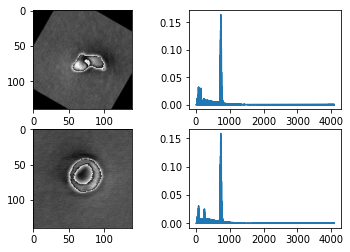

------ Training Images (RGB) ------ 
Shape =  (18696, 140, 140, 3)
Min and Max Values =  [0.0, 1.0]
------ Training Labels ------ 
Shape =  (18696, 8)
------ Validation Images (RGB) ------ 
Min and Max Values =  [0.0, 1.0]
Shape =  (4675, 140, 140, 3)
------ Validation Labels ------ 
Shape =  (4675, 8)


In [10]:
# Split training dataset into training and validation
from sklearn.model_selection import train_test_split
xTrain, xVal, yTrain, yVal = train_test_split(imgTrain_noOutliers, yTrainInt_noOutliers, test_size=0.2, random_state=1)
del imgTrain_noOutliers
sTrain, sVal, yTrain, yVal = train_test_split(specTrain_noOutliers, yTrainInt_noOutliers, test_size=0.2, random_state=1)
del specTrain_noOutliers, yTrainInt_noOutliers

# Convert to categorical variables for training with softmax activation function in the final layer
yTrainCat = tf.keras.utils.to_categorical(yTrain)
yValCat = tf.keras.utils.to_categorical(yVal)

# Plot a couple of examples and print the relevant dimensions
plt.figure()
plt.subplot(221)
plt.imshow(xTrain[0,:,:, :])
plt.subplot(222)
plt.plot(sTrain[0,:])
plt.subplot(223)
plt.imshow(xVal[0,:,:, :])
plt.subplot(224)
plt.plot(sVal[0,:])
plt.show()

yTrain = tf.keras.utils.to_categorical

print('------ Training Images (RGB) ------ ')
print('Shape = ', xTrain.shape)
print('Min and Max Values = ', [xTrain.min(), xTrain.max()])
print('------ Training Labels ------ ')
print('Shape = ', yTrainCat.shape)
print('------ Validation Images (RGB) ------ ')
print('Min and Max Values = ', [xVal.min(), xVal.max()])
print('Shape = ', xVal.shape)
print('------ Validation Labels ------ ')
print('Shape = ', yValCat.shape)

## Build the CNN model

### Input Layer
* 224x224 RGB image (3 channels)

### 1st Convolutional Block
* 2 convolutional layers
    * Filters: 64; Pixel size: 3x3; Stride: 1; Activation function: ReLU
* 1 max-pooling layer
    * Pixel size: 2x2; Stride: 2
    
### 2nd Convolutional Block
* 2 convolutional layers
    * Filters: 128; Pixel size: 3x3; Stride: 1; Activation function: ReLU
* 1 max-pooling layer
    * Pixel size: 2x2; Stride: 2
    
### 3rd Convolutional Block
* 3 convolutional layers
    * Filters: 256; Pixel size: 3x3; Stride: 1; Activation function: ReLU
* 1 max-pooling layer
    * Pixel size: 2x2; Stride: 2

### 4th & 5th Convolutional Blocks
* 3 convolutional layers
    * Filters: 512; Pixel size: 3x3; Stride: 1; Activation function: ReLU
* 1 max-pooling layer
    * Pixel size: 2x2; Stride: 2
    
### 1st Fully-connected Layer
* 4096 nodes
* ReLU activation function
* 50% dropout rate

### 2nd Fully-connected Layer
* 4096 nodes
* ReLU activation function
* 50% dropout rate

### Output Layer
* 8 nodes
* Softmax activation function

In [11]:
# checkpoint_path = execution_path + "/Defect_Classification/cnn_model_trained/cnn_model_normalized_X_try2/cp.ckpt"
# checkpoint_dir = os.path.dirname(checkpoint_path)
p.dropoutRate = 0.01 # 0.01 --> 95% test accuracy
class CNN():
    def buildModel(self):
        # Input structure

        CNNinput = Input(shape = (140,140, 3))

        specInput = Input(shape = (4096))
        # allInputs = Input(shape = (140,140, 3, 4096))
        # CNNinput = allInputs[:, :, :, :, 0]
        
        
        # 1st Convolutional block
        x = Conv2D(filters=64, kernel_size = (3, 3), strides = 1, padding = 'same', 
                   activation='relu')(CNNinput)
        x = Conv2D(filters=64, kernel_size = (3, 3), strides = 1, padding = 'same', 
                   activation='relu')(x)
        x = MaxPool2D(pool_size=(2,2), strides = 2, padding = 'same')(x)

        # 2nd Convolutional block
        for i in range(0, 2):
            x = Conv2D(filters=128, kernel_size = (3, 3), strides = 1, padding = 'same', 
                       activation='relu')(x)
        x = MaxPool2D(pool_size=(2,2), strides = 2, padding = 'same')(x)

        # 3rd Convolutional block
        for i in range(0, 3):
            x = Conv2D(filters=256, kernel_size = (3, 3), strides = 1, padding = 'same', 
                       activation='relu')(x)
        x = MaxPool2D(pool_size=(2,2), strides = 2, padding = 'same')(x)

        # 4th Convolutional block
        for i in range(0, 3):
            x = Conv2D(filters=512, kernel_size = (3, 3), strides = 1, padding = 'same', 
                       activation='relu')(x)
        x = MaxPool2D(pool_size=(2,2), strides = 2, padding = 'same')(x)

        # 5th Convolutional block
        for i in range(0, 2):
            x = Conv2D(filters=512, kernel_size = (3, 3), strides = 1, padding = 'same', 
                       activation='relu')(x)
        x = MaxPool2D(pool_size=(2,2), strides = 2, padding = 'same')(x)

        # Fully connected layers
        x = Flatten()(x)

        concat_layer= tf.keras.layers.Concatenate()([x, specInput]) #!! AB: here!
        x = concat_layer

        for i in range(0,3):
            x = Dense(units = 4096, activation ='relu')(x) 
            x = Dropout(p.dropoutRate)(x)

        CNNoutput = Dense(units = 8, activation ='softmax')(x)
        # CNNoutput = Dense(units = 1, activation ='sigmoid')(x)

        # Create model
        # model = Model(inputs = CNNinput, outputs = CNNoutput)
        
        model = Model(inputs = [CNNinput, specInput], outputs = CNNoutput)
        return model
    
    def trainCNN(self, model, xTrain, yTrain, xVal, yVal):

        model.compile(optimizer = 'Adam',
              # loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), metrics=['accuracy'])
              # loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False), metrics=['accuracy'])
        
        # cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True, verbose=1)
        
        history = model.fit(xTrain, yTrain, epochs=10, 
                            validation_data=(xVal, yVal))
        return history

In [12]:
# Instantiate object
cnn = CNN()
model = cnn.buildModel()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 140, 140, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 140, 140, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 140, 140, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 70, 70, 64)   0           conv2d_1[0][0]                   
______________________________________________________________________________________________

## Train the CNN

In [13]:
# Train the CNN
history = cnn.trainCNN(model, [xTrain, sTrain], yTrainCat, [xVal, sVal], yValCat)

cnnModel = history.model
cnnModel.save(execution_path+'/Defect_Classification/cnn_model_trained/cnn_normalized_X_8_classes')
historyMat = history.history
np.save(execution_path+'/Defect_Classification/cnn_model_trained/history_3_classes', historyMat)

Epoch 1/10
585/585 [==============================] - 1600s 3s/step - loss: 0.7082 - accuracy: 0.7676 - val_loss: 0.4345 - val_accuracy: 0.8417
Epoch 2/10
585/585 [==============================] - 1585s 3s/step - loss: 0.4286 - accuracy: 0.8590 - val_loss: 0.5386 - val_accuracy: 0.8372
Epoch 3/10
585/585 [==============================] - 1569s 3s/step - loss: 0.3868 - accuracy: 0.8717 - val_loss: 0.3226 - val_accuracy: 0.9029
Epoch 4/10
585/585 [==============================] - 1569s 3s/step - loss: 0.3602 - accuracy: 0.8844 - val_loss: 0.2982 - val_accuracy: 0.9076
Epoch 5/10
585/585 [==============================] - 1566s 3s/step - loss: 0.3448 - accuracy: 0.8868 - val_loss: 0.2481 - val_accuracy: 0.9202
Epoch 6/10
585/585 [==============================] - 1566s 3s/step - loss: 0.3012 - accuracy: 0.9049 - val_loss: 0.3128 - val_accuracy: 0.9279
Epoch 7/10
585/585 [==============================] - 1576s 3s/step - loss: 0.2899 - accuracy: 0.9092 - val_loss: 0.2298 - val_accuracy:

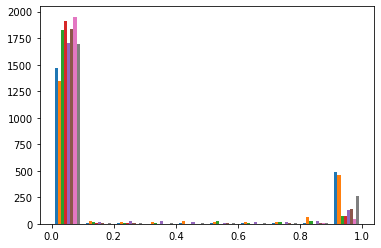

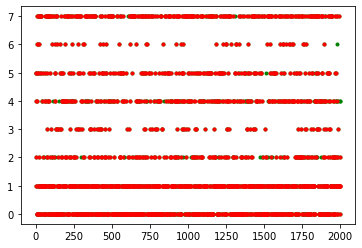

In [14]:
# Load a previously trained model
# model.load_weights(execution_path + '/Defect_Classification/cnn_model_trained/cnn_normalized_X_3_classes')
# cnnModel = model

yPredTrain = cnnModel.predict([xTrain[0:2000, :, :, :], sTrain[0:2000]])

plt.figure()
plt.hist(yPredTrain.argmax(1))
plt.show()

plt.figure()
plt.plot(yTrainCat[0:2000].argmax(1), 'g.')
plt.plot(yPredTrain.argmax(1), 'r.')

In [17]:
# del valImagesRGB, yVal#, trainImagesRGB, yTrain
xTest = np.load(execution_path+'/../Data/imgTest.npy')
sTest = np.load(execution_path+'/../Data/specTest.npy')
yTest = np.load(execution_path+'/../Data/yTest.npy')
yTestInt = (yTest.argmax(axis=1)).reshape(-1,1)

# # Pick classes 0, 1 and y from the test data
# idxClass0and1 = np.where(yTestInt<2)[0]
# idxClass7 = np.where(yTestInt==7)[0]
# yTestInt[idxClass7, :] = 2 
# idxPickClass = np.concatenate([idxClass0and1, idxClass7])
# yTestInt = yTestInt[idxPickClass, :]
# xTest = xTest[idxPickClass, :, :, :]
# sTest = sTest[idxPickClass, :]

yTestCat = tf.keras.utils.to_categorical(yTestInt)
yPred = cnnModel.predict([xTest, sTest])

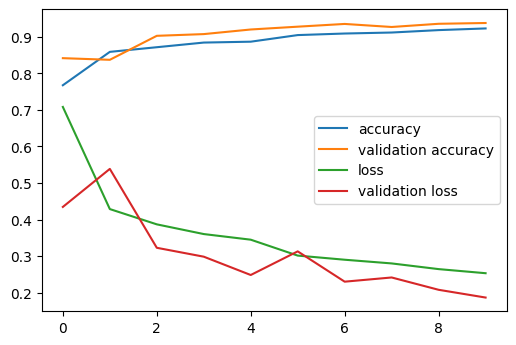

In [39]:
# plt.figure(dpi=150)
# plt.subplot(421)
# plt.imshow(xTest[0,:,:,:])
# plt.subplot(422)
# plt.imshow(xTest[1,:,:,:])
# plt.subplot(423)
# plt.imshow(xTest[5,:,:,:])
# plt.subplot(424)
# plt.imshow(xTest[20,:,:,:])

plt.figure(dpi=100)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'validation accuracy')
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.legend()
plt.show()

Test accuracy =  0.93316585
No. of Misclassified Test Points =  266
No. of Total Test Points =  3980


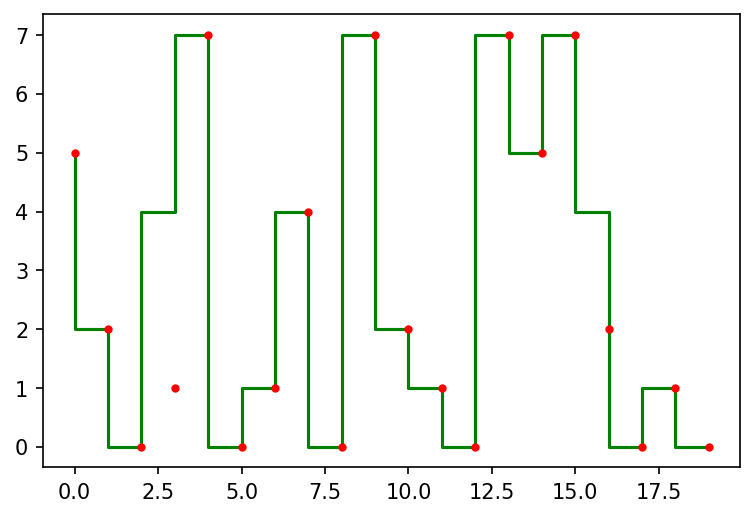

In [26]:
accuracyMetricFn = tf.keras.metrics.Accuracy()
# accuracyMetricFn.update_state(yTrainCat[0:2000], yPredTrain)
# print('Train accuracy = ', accuracyMetricFn.result().numpy())
# print('No. of Misclassified Training Points = ', len(np.where(yTrainCat[0:1000].argmax(1)!=yPredTrain.argmax(1))[0]))
# print('No. of Total Training Points = ', yTrainCat[0:1000].shape[0])
accuracyMetricFn.update_state(yTestCat.argmax(1), yPred.argmax(1))
print('Test accuracy = ', accuracyMetricFn.result().numpy())
print('No. of Misclassified Test Points = ', len(np.where(yTestCat.argmax(1)!=yPred.argmax(1))[0]))
print('No. of Total Test Points = ', yTestCat.shape[0])


plt.figure(dpi=150)
# plt.subplot(121)
# plt.step(yTrainCat.argmax(1), 'g')
# plt.step(yPredTrain.argmax(1), 'r.', markersize=0.1)
# plt.subplot(122)
plt.step(yTestCat[0:20].argmax(1), 'g')
plt.step(yPred[0:20].argmax(1), 'r.')#, markersize=0.1)
plt.show()

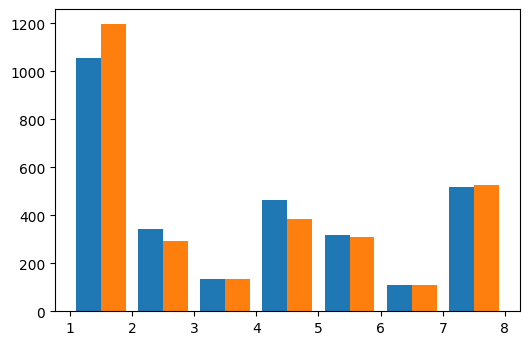

In [35]:
plt.figure(dpi=100)
plt.hist([yTestCat.argmax(1), yPred.argmax(1)], np.linspace(1, 8, 8))
plt.show()

In [36]:
def accuracyManual(yRealClass, yPredClass):
  Ntotal = yRealClass.shape[0]
  idx = np.where(yRealClass==yPredClass)[0]
  Ncorrect = len(idx)
  acc = Ncorrect*100.0/Ntotal
  return acc

acc = accuracyManual(yTestCat.argmax(1), yPred.argmax(1))
print(acc)

93.31658291457286


## Old Code

### Run object detection algorithm (Later)

In [ ]:
'''
execution_path = os.getcwd()

detector = ObjectDetection()
# detector.setModelTypeAsRetinaNet()
# detector.setModelPath(os.path.join(execution_path , "resnet50_coco_best_v2.1.0.h5"))
detector.setModelTypeAsYOLOv3()
detector.setModelPath(os.path.join(execution_path , "pretrained-yolov3.h5"))
detector.loadModel()
# detections = detector.detectObjectsFromImage(input_image=os.path.join(execution_path, "defectImage.jpeg"), output_image_path=os.path.join(execution_path , "defectImageID.jpg"))
detections = detector.detectObjectsFromImage(input_type = "array", input_image=aaRGB, output_image_path=os.path.join(execution_path , "Defect_Images/defectImageID.jpg"))


for eachObject in detections:
    print(eachObject["name"] , " : " , eachObject["percentage_probability"] )
    
'''

In [ ]:
# Load
# [...]

# Outlier detection using clustering?
# [...]

# Data augmentation by roating 60 degrees
# [...]
# rotate = tfa.image.rotate(img, tf.constant(np.pi/3))
# visualize(image, rotated)
